# Chapter 10. 로지스틱 회귀의 심화
## 2. 다중클래스 분류를 코드로 구현하기
### 01 - mnist 데이터셋의 이해
- 사이킷런(scikit-learn)을 사용하여 다중클래스 분류를 다룸
    - 먼저 다중클래스 분류 데이터셋에 대해 이해해야 함
- 다양한 데이터셋 중 손글씨를 숫자로 인식하는 이미지 분류 문제를 가장 많이 사용
    - 흔히 **mnist**데이터셋이라 부름
        - 뉴럴 네트워크(neural network)에서 분류 정확도의 성능을 보여줬던 데이터셋으로 유명

- 컴퓨터는 이미지를 이미지 그 자체로 인식하지 못 함
    - 해당 이미지를 일종의 숫자로 변환하여 인식
    - 이미지를 일종의 점(dot)으로 생각하면 m $\times$ n만큼의 공간이 존재
        - 그 공간 안에서 색깔이 진할수록 높은 값을 가지고 색깔이 옅을수록 낮은 값을 가진다 이해할 수 있음

### 02 - 데이터 불러오기
- 사이킷런의 데이터를 불러오기 위해 **datasets**모듈을 호출
    - **load_digits**함수를 사용하면 dict 타입 형태의 데이터를 불러올 수 있음
        - 기본적인 데이터는 **data** 키 값에 들어있음
        - $y$값에 해당하는 값은 **target**에 있음
        - **DESCR**을 보면 데이터에 대해 자세히 설명되어 있음

In [5]:
from sklearn import datasets
digit_dataset = datasets.load_digits()
digit_dataset.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [6]:
# 좀 더 자세히 데이터를 확인하기 위해 아래 코드 실행
digit_dataset["images"].shape
# 첫 번째 값인 1797은 데이터의 개수
# 그 다음에 나오는 8, 8은 가로와 세로 8칸씩 총 64칸이 존재하고 그 값이 모두 채워졌단 의미

(1797, 8, 8)

In [7]:
digit_dataset["target"][0]
# target 데이터의 0번째 값은 0

0

In [8]:
digit_dataset["images"][0]
# images 데이터의 0번째 값을 출력하면 배열인 array 형태로 나옴

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

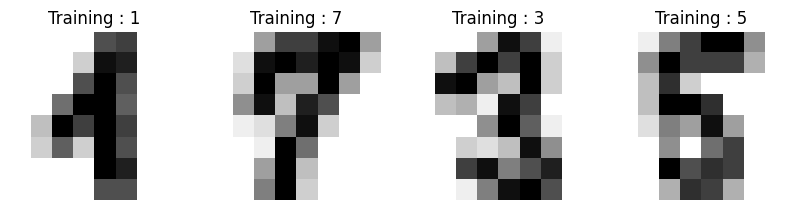

In [11]:
# 위 결과값에서 각 숫자가 클수록 실제 검정색에 가까운 값이 나옴
# 이를 matplotlib 도구를 사용하여 시각화하면 아래 코드와 같음
import matplotlib.pyplot as plt
from random import randint

_, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 3))
# 하나의 창에 여러 개의 그래프를 그리는 subplots를 4개 생성

for ax in axes :
    # 각 subplot에 들어갈 숫자를 위해 for문이 돌 때마다 하나의 값을 생성
    num = randint(1, 1000)
    # 각 값은 randint 함수로 인해 랜덤하게 1에서 1000 사이 숫자를 뽑아서 변수 num에 할당
    image = digit_dataset["images"][num]
    label = digit_dataset["target"][num]
    ax.set_axis_off()
    ax.imshow(image, cmap = plt.cm.gray_r, interpolation = 'nearest')
    # 그 숫자를 사용하여 digit_dataset에서 값을 하나씩 가져오고, imshow 함수를 사용하여 해당 값을 표시
    ax.set_title('Training : %i' % label)

- 이 데이터는 8 $\times$ 9 행렬이므로 2D 이미지로 표현됨

- 아래 코드와 같이 **digit_dataset["data"]**로 받아오면 총 64개의 피쳐(feature)를 가진 하나의 데이터로 받을 수 있음

In [12]:
digit_dataset["data"][0].shape

(64,)

### 03 - 데이터 분류하기
- 데이터를 분류하기 위해서는 먼저 데이터를 훈련 데이터셋과 테스트 데이터셋으로 구분

In [13]:
from sklearn.model_selection import train_test_split

X = digit_dataset["data"]
y = digit_dataset["target"]
# 데이터셋 data와 target에 있는 값들을 각각 X, y 변수에 할당
X_train, X_test, y_train, y_test = train_test_split(X, y)
# train_test_split으로 훈련 데이터셋과 테스트 데이터셋으로 구분하여 데이터 X, y를 각 변수에 할당

### 04 - 모델 생성하기
- 다중클래스 분류에서는 아래 코드와 같이 두 가지 방식으로 모델을 구성할 수 있음
    - **ovr**은 각각의 클래스 모드를 모두 이진모델(binary model)로 만들어 학습하는 방식
    - **multinomial**은 소프트맥스 함수(softmax function)를 사용하여 계산하는 방식
        - 해당 학습을 위해 경사하강법을 사용하는 매개변수 **solver**를 **sag**으로 변경해야 함

In [14]:
from sklearn.linear_model import LogisticRegression

logreg_ovr = LogisticRegression(multi_class= "ovr")
logreg_softmax = LogisticRegression(multi_class= "multinomial", solver= "sag")

logreg_ovr.fit(X_train, y_train)
logreg_softmax.fit(X_train, y_train)

c:\workspace\machinelearning\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\workspace\machinelearning\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='sag')

### 05 - 성능 측정하기
- 일반적으로 다중클래스 분류도 기존의 혼동행렬 사용

- 아래 코드와 같이 각 클래스 대비 예측한 값을 행렬 형태로 표현 가능

In [15]:
from sklearn.metrics import confusion_matrix
y_pred = logreg_ovr.predict(X_test).copy()
y_true = y_test.copy()
confusion_matrix(y_true, y_pred)

array([[44,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 46,  0,  1,  0,  0,  1,  0,  3,  2],
       [ 0,  0, 44,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 48,  0,  1,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 41,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 41,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 52,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 39,  0,  1],
       [ 0,  2,  0,  0,  1,  0,  0,  0, 40,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  1, 38]], dtype=int64)

In [16]:
# 또한 이를 각 라벨별로 수치화시킨다면
# classification_report 함수를 사용하여 라벨별로 분류 성능을 표시할 수 있음
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.94      0.87      0.90        53
           2       1.00      0.98      0.99        45
           3       0.96      0.98      0.97        49
           4       0.95      0.98      0.96        42
           5       0.98      1.00      0.99        41
           6       0.98      1.00      0.99        52
           7       0.97      0.97      0.97        40
           8       0.91      0.93      0.92        43
           9       0.93      0.95      0.94        40

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450



- 한 가지 차이가 있음
    - 각 라벨별이 아닌 통합적인 성능을 나타내려면 정밀도(precision), 민감도(recall), F1 스코어 등을 사용할 수 있음
        - 이러한 지표들은 micro를 선택하면 전체 평균값, macro를 선택하면 각 라벨별 결과의 합에 대한 평균을 나타냄
            - micro : classification_report의 각 라벨별 평균, 즉 avg 값을 취함
            - macro : 각 라벨별로 False Positive와 True Positive 값을 모두 더해서 True Positive 값으로 나눔

In [17]:
result = confusion_matrix(y_true, y_pred)
result.diagonal().sum() / result.sum(axis= 0).sum()

0.9622222222222222

- 만약 각 라벨들의 데이터 개수가 차이가 난다면 micro를 선택하여 얻는 결과가 더 중요
- 그렇지 않을 경우는 macro로 선택하여 라벨의 평균적인 성능을 나타낼 수 있음

- 이를 위해 아래 코드와 같이 **precision_score** 함수에 매개변수 **average**를 변경

In [18]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average= "micro")

0.9622222222222222

In [19]:
precision_score(y_true, y_pred, average= "macro")

0.9620506611342872

In [20]:
precision_score(y_true, y_pred, average= None)

array([1.        , 0.93877551, 1.        , 0.96      , 0.95348837,
       0.97619048, 0.98113208, 0.975     , 0.90909091, 0.92682927])